## Importing the time series and setting date time

In [12]:
import pandas as pd # pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
# from sklearn import impute
from  scipy.stats import skew, kurtosis, shapiro
import datetime


plt.rc('axes', linewidth=2)
plt.rc('axes', labelsize= 16)
plt.rc('axes',titlesize = 18)
plt.rc('legend',fontsize=14)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rc('figure',figsize=(10,8))
#######################################################################################

# consumptionLoad = pd.read_csv("D:\Onedrive\Leuven\Final project\data\consumption.csv",index_col = "meter_id")
# new_index = []
# for i in np.arange(1,len(consumptionLoad.index)+1):
#     new_index.append("meter_" + str(i))
# new_index = pd.Series(new_index)
# consumptionLoad.set_index(new_index,inplace=True)
# consumptionLoad_T = consumptionLoad.transpose()
# dates = pd.to_datetime(consumptionLoad_T.index)
# consumptionLoad_T = consumptionLoad_T.set_index(dates)
# consumptionLoad_T.index.rename('date',inplace=True)


# consumptionLoad_T.to_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\consumptionLoad_T.csv")

#######################################################################################
def figure_layout(figsize=(10,8),titel="",xlabel="",ylabel="",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16):
    plt.figure(figsize=figsize)
    ax1 = plt.gca()
    plt.rc('legend',fontsize=fontsize_legend)
    plt.title(titel, fontsize=fontsize_titel, fontweight = 'bold')
    plt.grid(True)
    plt.xlabel(xlabel, fontsize=fontsize_axis)
    plt.ylabel(ylabel, fontsize=fontsize_axis)
    for tick in ax1.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize_ticks)
    #         tick.label1.set_fontweight('bold')
    for tick in ax1.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize_ticks)
    #     tick.label1.set_fontweight('bold')
    
    return ax1

In [13]:
# To reduce time when loading the data
# consumptionLoad_T = pd.read_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\consumptionLoad_T.csv",parse_dates=['date'], index_col='date')

In [14]:
# def visualization_NaN(months_show,meter_show,rows = 4, columns = 3):
#     if rows*columns != len(months_show):
#         raise Exception("The number of months doesn't match with the amount of provided figures")
#     originalMeter = pd.DataFrame(data=consumptionLoad_T[meter_show])
#     originalMeter["month"] = originalMeter.index.month_name()
#     originalMeter["day"] = originalMeter.index.day
#     r=0
#     c=0
#     _, axes = plt.subplots(rows,columns)

#     for m in months_show:
#         originalMeter_month = originalMeter[originalMeter["month"] == m]

#         index = []
#         lost = []
#         full = []

#         for i in np.arange(originalMeter_month["day"][0],originalMeter_month["day"][-1]+1,1):
#             dataDay = originalMeter_month[originalMeter_month["day"] == i]
#             index.append(str(i))
#             nNaN = dataDay[meter_show].isnull().sum()
#             lost.append(nNaN)
#             full.append(len(dataDay)-nNaN)

#         df = pd.DataFrame(index=index)
#         df["full"] = full
#         df["lost"] = lost

#         df.plot.bar(stacked=True,figsize=(30,24),ax=axes[r][c],title= m)

#         if c == columns - 1:
#             r += 1
#             c = 0
#         else:
#             c += 1
    
#     plt.show()

## Selecting the meters that have observations in all months.

In [15]:
# data_monthly = consumptionLoad_T.resample('MS',axis=0).sum()
# new_index_months = data_monthly.index.month_name()
# data_monthly.set_index(new_index_months,inplace=True)
# ### Create an empty dataframe to store the first index of non zero value
# first_non_zero_ind = pd.DataFrame(index = ['first_non_zero_row'])

In [16]:
# ### Create empty list to store IDs of TS to remove (because they are full of zeros/NaN only)
# ID_NaN = []
# ### Loop through the columns and though the indexes of the dataframe
# for col_ind in range(len(data_monthly.columns)):
#     ID = data_monthly.columns[col_ind]
#     for row_ind in range(len(data_monthly.index)):
# ### we check for non zero values, but only if a first value has not been selected yet 
#         if (data_monthly.iloc[[row_ind],[col_ind]].values != 0) and (not ID in first_non_zero_ind.columns):
#             first_non_zero_ind.insert(col_ind,ID,[row_ind]) #The value inserted indicates when the data starts
# ### in the case of an 'empty' TS, we place a NaN and we save the ID of this TS     
#         elif ( all(val == 0 for val in data_monthly[[ID]].values) ) and (not ID in first_non_zero_ind.columns):
#             first_non_zero_ind.insert(col_ind,ID,np.NaN)
#             ID_NaN.append(ID)

In [17]:
# print("Meter without data: {}.".format(ID_NaN))

In [18]:
# meters_with_full_data = first_non_zero_ind.columns[first_non_zero_ind.iloc[0] == 0]
# fullYeardata = consumptionLoad_T[meters_with_full_data]

In [19]:
# Directly loading in order to save time.
# fullYeardata.to_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\FullYeardata.csv")

In [20]:
fullYeardata = pd.read_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\FullYeardata.csv",parse_dates=['date'], index_col='date')

In [21]:
amount_measurements = fullYeardata.shape[0]
amount_meters = fullYeardata.shape[1]
print("The amount of measurements: {}.".format(amount_measurements))
print("The amount of meters: {}.".format(amount_meters))

The amount of measurements: 17520.
The amount of meters: 270.


## Investigating best way to subsitude the missing values

In [22]:
pct_NaN = fullYeardata.isnull().sum().sort_values().div(amount_measurements).mul(100)
print("The amount of missing data per smart meter ranges between {} % and {} %.".format(np.around(pct_NaN.min(),2),np.around(pct_NaN.max(),2)))

The amount of missing data per smart meter ranges between 1.1 % and 35.34 %.


In [23]:
data_MV = fullYeardata.copy(deep=True)
data_MV["month"] = data_MV.index.month_name()
data_MV = data_MV[data_MV["month"] == "March"]
data_MV.drop("month",axis='columns', inplace=True)
# visualization_NaN(["January","February","March","April","May","June","July","August","September","October","November","December"],"meter_3002")
print("Amount of meters with no missing days in the month March: {}.".format(len(data_MV.columns[data_MV.isnull().sum() == 0])))
col_no_missing = list(data_MV.columns[data_MV.isnull().sum() == 0])


Amount of meters with no missing days in the month March: 181.


In [24]:
reference = data_MV[col_no_missing].copy(deep=True)
test = reference.copy(deep = True)

In [25]:
# Select randomly 7 days that will be removed. 
removed_days = dict()
test["day"] = test.index.day
for col_ind in range(len(test.columns)):
    ID = test.columns[col_ind]
    rand_days = np.random.randint(2,31,size=7)
    removed_days[ID] = rand_days
    for i in rand_days:
        test.loc[test["day"] == i,ID] = np.nan
test.drop("day",axis=1,inplace = True)
print(test.isnull().sum())

meter_2979    336
meter_2981    336
meter_2983    336
meter_2986    336
meter_2988    288
             ... 
meter_3239    288
meter_3240    336
meter_3241    336
meter_3243    288
meter_3246    336
Length: 181, dtype: int64


In [26]:
# First look into a single meter
part_test = test.loc[:, 'meter_2981'] 

Data after 7 days have been removed.

meter_2981    336
dtype: int64


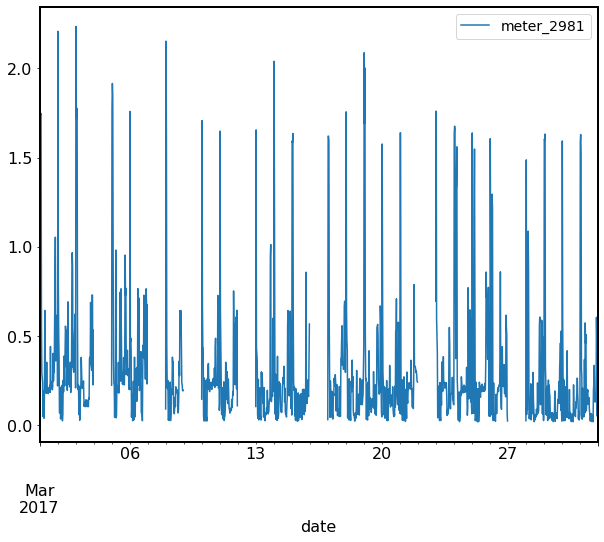

In [27]:
df = pd.DataFrame(index = part_test.index, data = part_test)
print(df.isnull().sum())
df.plot()

In [28]:
# Estimate the missing data based on previous and future observations
def estimated_mean_signal(test):
    for col_ID in test.columns:
        missing_index = test.loc[pd.isna(test[col_ID]), :].index
        for date in missing_index:
            n = 0
            next_measure_index = date + datetime.timedelta(days= 1)
            next_measure_value = test.loc[[next_measure_index],[col_ID]].iloc[0,0]
            
            previous_measure_index = date + datetime.timedelta(days= -1)
            previous_measure_value = test.loc[[previous_measure_index],[col_ID]].iloc[0,0]

            while np.isnan(next_measure_value) or np.isnan(previous_measure_value):
                n += 1
                               
                if np.isnan(next_measure_value) and np.isnan(previous_measure_value):

                    next_measure_index = date + datetime.timedelta(days= n + 1)
                    next_measure_value = test.loc[[next_measure_index],[col_ID]].iloc[0,0]
                    previous_measure_index = date + datetime.timedelta(days= -1*(n + 1))
                    previous_measure_value = test.loc[[next_measure_index],[col_ID]].iloc[0,0]
                
                elif np.isnan(next_measure_value):
                    next_measure_index = date + datetime.timedelta(days= n + 1)
                    next_measure_value = test.loc[[next_measure_index],[col_ID]].iloc[0,0]

                elif np.isnan(previous_measure_value):
                    previous_measure_index = date + datetime.timedelta(days= -1*(n + 1))
                    previous_measure_value = test.loc[[next_measure_index],[col_ID]].iloc[0,0]

                else:
                    raise Exception("Should have been excepted by one of the previous cases.")
                    

            estimation = (next_measure_value + previous_measure_value)/2
            test.loc[date,col_ID] = estimation

# Function will give error if the first or last day of the serie are missing (1 jan or 31 dec) --> exceptional. 



In [29]:
df_copy = df.copy(deep=True)

In [30]:
estimated_mean_signal(df_copy)

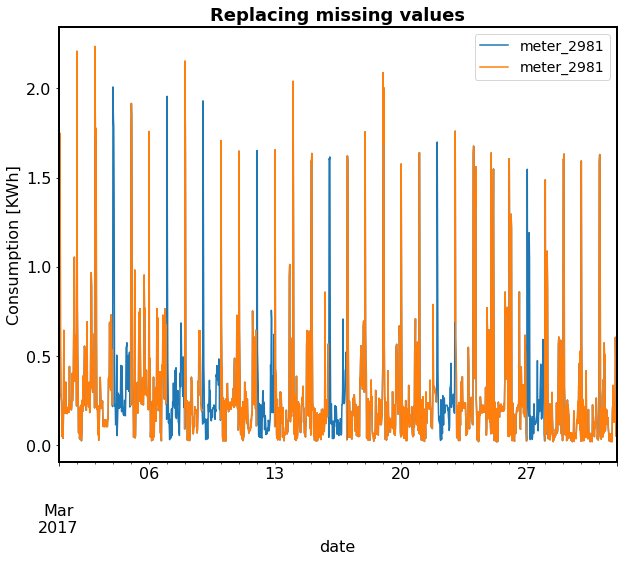

In [31]:
axis = figure_layout(figsize=(10,8),titel="Replacing missing values",xlabel="",ylabel="Consumption [KWh]",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16)
df_copy.plot(ax=axis,legend= "Replaced values")
df.plot(ax=axis,legend= "Missing values")
# It is possible that a prediction model can be considered to predict the missing values

### Using simply the mean of the signal to replace the missing values.

In [32]:
df_copy2 = df.copy(deep=True)

In [33]:
my_imputer = SimpleImputer()
data_with_imputed_values = my_imputer.fit_transform(df_copy2) # calculating the mean of each column and switch it with the missing values of the column
df_copy2 = pd.DataFrame(data = data_with_imputed_values,index=df_copy2.index,columns=df_copy2.keys())
pct_NaN = df_copy2.isnull().sum().sort_values().div(1).mul(100)
print("The amount of missing data per smart meter ranges between {}% and {}%.".format(pct_NaN.min(),pct_NaN.max()))

The amount of missing data per smart meter ranges between 0.0% and 0.0%.


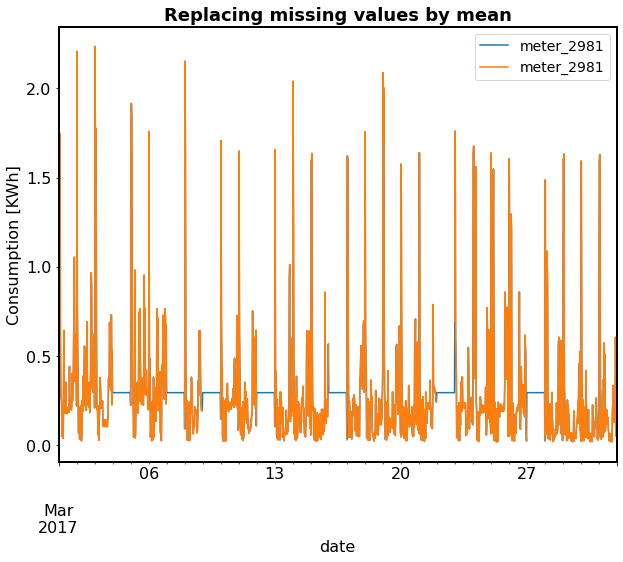

In [34]:
axis = figure_layout(figsize=(10,8),titel="Replacing missing values by mean",xlabel="",ylabel="Consumption [KWh]",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16)
df_copy2.plot(ax=axis,legend= "Replaced values")
df.plot(ax=axis,legend= "Missing values")

### Comparing the two methods by calculating the MSE based on all the meters in the test dataframe. (181 meters)

In [35]:
print(df.isnull().sum())
missing_index = df.loc[pd.isna(test['meter_2981']), :].index

meter_2981    336
dtype: int64


In [36]:
part_ref = reference.loc[:, 'meter_2981']
print("The amount of NaN values in the reference: {}".format(part_ref.isnull().sum()))

The amount of NaN values in the reference: 0


In [37]:
MSE = df_copy.subtract(part_ref,axis=0).pow(2).sum().div(amount_measurements)[0]
print(MSE)
MSE_mean = df_copy2.subtract(part_ref,axis=0).pow(2).sum().div(amount_measurements)[0]
print(MSE_mean)

0.0018884398687214609
0.0028225818527172646


['MSE Average Neighbours', 'MSE Mean']


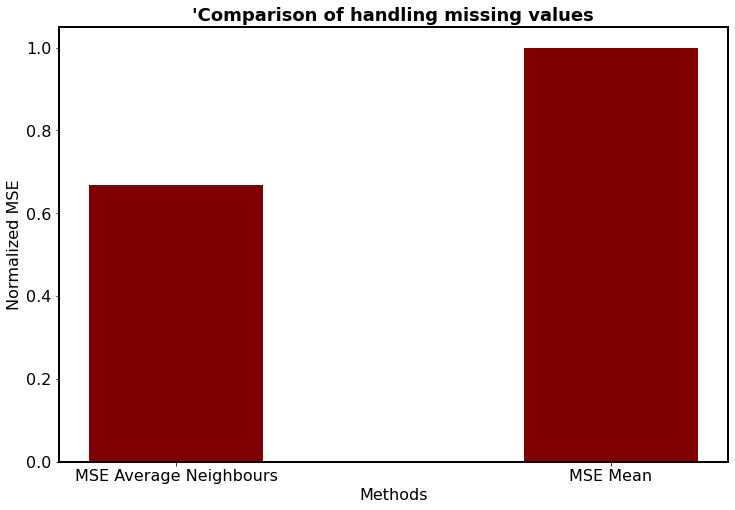

In [38]:
data = {'MSE Average Neighbours': MSE/MSE_mean, 'MSE Mean': MSE_mean/MSE_mean} # Normalized
MSEs = list(data.keys()) 
values = list(data.values()) 
   
axis = figure_layout(figsize=(12,8),titel="'Comparison of handling missing values",xlabel="Methods",ylabel="Normalized MSE",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16)
axis.grid(False)
print(MSEs)  
# creating the bar plot 
axis.bar(MSEs, values, color ='maroon',width = 0.4) 
  
plt.show() 

### Now that the MSE average Neighbours method is shown the most effective, this is applied on whole the dataset fullYeardata.

It is taking a while to replace all the values in the test data. Have written it to a csv file that then is loaded. 


In [39]:
test_AN = test.copy(deep=True)

In [40]:
print(test_AN.isnull().sum())
estimated_mean_signal(test_AN)

meter_2979    336
meter_2981    336
meter_2983    336
meter_2986    336
meter_2988    288
             ... 
meter_3239    288
meter_3240    336
meter_3241    336
meter_3243    288
meter_3246    336
Length: 181, dtype: int64


In [42]:
print(test_AN.isnull().sum())

meter_2979    0
meter_2981    0
meter_2983    0
meter_2986    0
meter_2988    0
             ..
meter_3239    0
meter_3240    0
meter_3241    0
meter_3243    0
meter_3246    0
Length: 181, dtype: int64


In [43]:
# test_AN.to_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\Test_data_MV_replaced_complete.csv")

In [46]:
# reference.to_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\Reference.csv")

In [47]:
# test.to_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\Test.csv")

In [115]:
# test1 = pd.read_csv("D:\Onedrive\Leuven\Final project\data\Test_data_MV_replaced.csv",parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')
# print("The amount of missing values: {}.".format(test1.isnull().sum(axis=0).sum()))

The amount of missing values: 0.


In [69]:
MSE_complete = test_AN.subtract(reference,axis=0).pow(2).sum(axis=0).sum(axis=0)/amount_measurements
print(MSE_complete)


0.20827367942808664


In [71]:
print("The amount of NaN values in the test: {}".format(test.isnull().sum().sum()))

The amount of NaN values in the test: 54528


In [72]:
my_imputer = SimpleImputer()
data_with_imputed_values = my_imputer.fit_transform(test) # calculating the mean of each column and switch it with the missing values of the column
test_M = pd.DataFrame(data = data_with_imputed_values,index=test.index,columns=test.keys())

In [73]:
pct_NaN = test_M.isnull().sum().sort_values().div(1).mul(100)
print("The amount of missing data per smart meter ranges between {}% and {}%.".format(pct_NaN.min(),pct_NaN.max()))

The amount of missing data per smart meter ranges between 0.0% and 0.0%.


In [74]:
MSE_M_complete = test_M.subtract(reference,axis=0).pow(2).sum(axis=0).sum(axis=0)/amount_measurements
print(MSE_M_complete)

0.25870168859788145


['MSE Average Neighbours', 'MSE Mean']


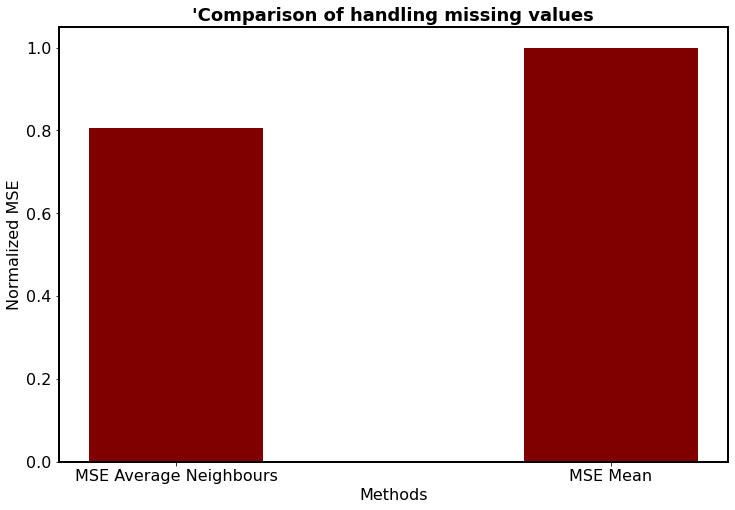

In [75]:
data = {'MSE Average Neighbours': MSE_complete/MSE_M_complete, 'MSE Mean': MSE_M_complete/MSE_M_complete} # Normalized
MSEs = list(data.keys()) 
values = list(data.values()) 
   
axis = figure_layout(figsize=(12,8),titel="'Comparison of handling missing values",xlabel="Methods",ylabel="Normalized MSE",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16)
axis.grid(False)
print(MSEs)  
# creating the bar plot 
axis.bar(MSEs, values, color ='maroon',width = 0.4) 
  
plt.show() 